In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math
from os import path
from datetime import datetime
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, MinMaxScaler
import operator

import keras
import keras.backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard

from utils.prepare_input_for_embedding import (read_df, create_features_training_time)

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

## RECURRENT NEURAL NETWORK LSTM : Quick try without working on optimization

In [5]:
data_path = "./data/"
data_filename = "cpu_slzq0b.csv"

In [6]:
df = read_df(data_path, data_filename)
df = create_features_training_time(df)
df.set_index("datetime", inplace=True)

In [10]:
df = df[["cpu"]]

In [11]:
dataset = df.values
dataset = dataset.astype('float32')

In [200]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [201]:
# split into train and test sets
train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

2052 228


In [202]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [203]:
# reshape into X=t and Y=t+1
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [204]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [205]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
2027/2027 [==============================] - 15s 8ms/step - loss: 0.1202
Epoch 2/50
2027/2027 [==============================] - 15s 8ms/step - loss: 0.0993
Epoch 3/50
2027/2027 [==============================] - 18s 9ms/step - loss: 0.0954
Epoch 4/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0938
Epoch 5/50
2027/2027 [==============================] - 15s 8ms/step - loss: 0.0916
Epoch 6/50
2027/2027 [==============================] - 17s 9ms/step - loss: 0.0896
Epoch 7/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0879
Epoch 8/50
2027/2027 [==============================] - 13s 7ms/step - loss: 0.0859
Epoch 9/50
2027/2027 [==============================] - 14s 7ms/step - loss: 0.0848
Epoch 10/50
2027/2027 [==============================] - 14s 7ms/step - loss: 0.0831
Epoch 11/50
2027/2027 [==============================] - 14s 7ms/step - loss: 0.0821
Epoch 12/50
2027/2027 [==============================] - 14s 7ms/step - lo

In [106]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [114]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict.flatten()
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict.flatten()

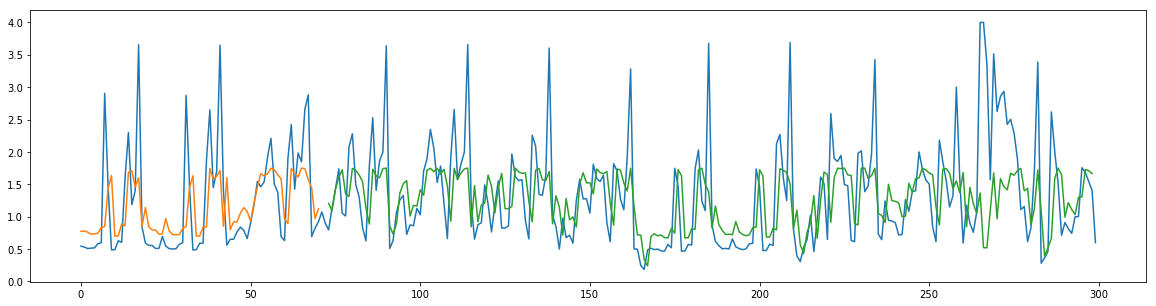

In [121]:
# plot baseline and predictions
plt.figure(figsize = (20,5))
plt.plot(scaler.inverse_transform(dataset)[-300:])
plt.plot(trainPredictPlot[-300:])
plt.plot(testPredictPlot[-300:])
plt.show()

#### CONCLUSTION : good potential but need to be tuned !!!